In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('train data shape: ',train.shape,'\ntest data shape: ',test.shape)

train data shape:  (10493, 15) 
test data shape:  (4507, 14)


In [3]:
# The first step is to convert the data type of the column (TRANSACTION TIME) to DateTime. 
# That can be done using .to_datetime() method in Pandas.
train['transaction time']= pd.to_datetime(train['transaction time'])
train['hour'] = train['transaction time'].dt.hour #returns the hour of the datetime(range 1 - 24)
train['dayofweek_name'] = train['transaction time'].dt.weekday_name #day of week of transaction
train['is_weekend'] = np.where(train['dayofweek_name'].isin(['Sunday','Saturday']),1,0) #weekend or nota

#Getting the period of the day from the hour feature
bins = [0,4,8,12,16,20,24]
period = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
train['period_of_day'] = pd.cut(train['hour'], bins=bins, labels=period)

#Getting the recent amount withdrawn or deposited
train['prev_tran'] = train['current bank amount'] - train['last bank amount']
#credit if the value is positive or debit if otherwise
train['credit_or_debit'] = ['credit' if x > 0 else 'debit' for x in train['prev_tran'] ]

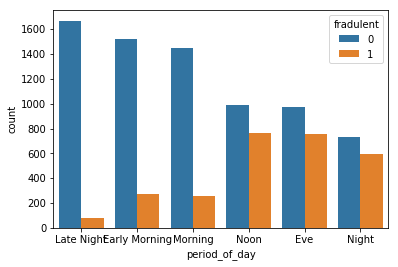

In [22]:
sns.countplot(train['period_of_day'],hue=train['fradulent'])

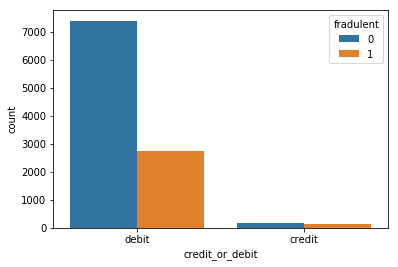

In [24]:
sns.countplot(train['credit_or_debit'],hue=train['fradulent'])

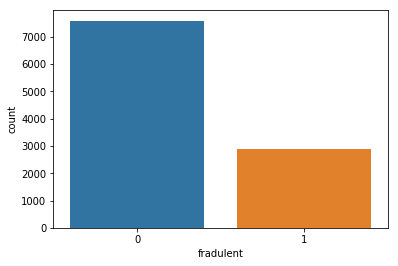

In [25]:
sns.countplot(train['fradulent'])

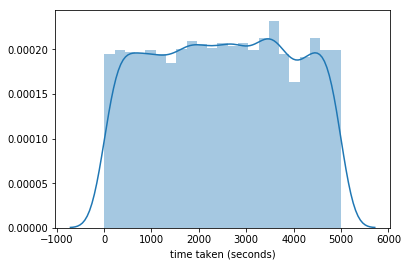

In [26]:
sns.distplot(train['time taken (seconds)'])

In [10]:
features = train[['current bank amount', 'last bank amount',
       'time taken (seconds)', 'most recent bank amount', 'account type',
       'age', 'occupation', 'credit card type',
       'account source verification', 'transaction source method',
       'account destination verification', 'dayofweek_name', 'is_weekend',
       'hour','prev_tran','credit_or_debit','period_of_day']]
X = pd.get_dummies(columns=['account type',
       'occupation', 'credit card type', 'credit_or_debit',
       'account source verification', 'transaction source method',
       'account destination verification', 'dayofweek_name','period_of_day'], data = features)
y = train['fradulent']  #target feature

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,    test_size=0.2, random_state=42, stratify = y)

In [8]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import auc, roc_auc_score

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
seed = 7
models = []
models.append(('Lr', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('Knn', KNeighborsClassifier()))
models.append(('Decision_Tree', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    results.append(score)
    names.append(name)
    msg = "%s: %f " % (name, score)
    print(msg)

Lr: 0.525685 
LDA: 0.759489 
Knn: 0.496915 
Decision_Tree: 0.629698 


In [16]:
test['transaction time']= pd.to_datetime(test['transaction time'])
test['hour'] = test['transaction time'].dt.hour #returns the hour of the datetime(range 1 - 24)
test['dayofweek_name'] = test['transaction time'].dt.weekday_name #day of week of transaction
test['is_weekend'] = np.where(test['dayofweek_name'].isin(['Sunday','Saturday']),1,0) #weekend or not

test['period_of_day'] = pd.cut(test['hour'], bins=bins, labels=period)

#Getting the recent amount withdrawn or deposited
test['prev_tran'] = test['current bank amount'] - test['last bank amount']
#credit if the value is positive or debit if otherwise
test['credit_or_debit'] = ['credit' if x > 0 else 'debit' for x in test['prev_tran'] ]

In [18]:
test = test[features.columns]
test = pd.get_dummies(columns=['account type',
       'occupation', 'credit card type', 'credit_or_debit',
       'account source verification', 'transaction source method',
       'account destination verification', 'dayofweek_name','period_of_day'], data = test)

In [19]:
model = LinearDiscriminantAnalysis()
model.fit(X, y)
predictions = model.predict_proba(test)[:,1]

In [20]:
sub = pd.read_csv('sample sub.csv')
sub.head()

,id,fradulent
0,bcus2993,1.0
1,bcus2994,1.0
2,bcus2995,1.0
3,bcus2996,1.0
4,bcus2997,1.0


In [21]:
sub['fradulent'] = predictions
sub[['id', 'fradulent']].to_csv('submission.csv', index = False)